<a href="https://colab.research.google.com/github/PaulRobertH/wine-ml-portfolio/blob/main/Macro_Driven_Wine_Return_Forecasting_(ML_Model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd

# Load your cleaned dataset
df = pd.read_csv('/content/drive/MyDrive/ML-Portfolio/data/cleaned_for_modeling.csv')

# Show all column names
print("🧾 Available columns in cleaned_for_modeling.csv:")
print(df.columns.tolist())


🧾 Available columns in cleaned_for_modeling.csv:
['Unnamed: 0', 'Liv-ex 100', 'US CPI', 'TVC_US10Y, 15', 'FX_GBPUSD, 1M', 'OANDA_EURUSD, 1M', 'FX_IDC_GBPEUR, 1M', 'FX_GBPJPY, 1M', 'HKEX_DLY_HSI1!, 1M (1)', 'Dollar Index (DXY)', 'S&P 500 Futures', 'CME_MINI_NQ1!, 1M', 'TVC_USOIL, 1M', 'PEPPERSTONE_COCOA, 1M', 'liv-ex Champagne 50', 'liv-ex Italy 100', 'liv-ex Rhone 100', 'liv-ex California 50', 'liv-ex Investables', 'Liv-ex Fine Wine 1000', 'Liv-ex Indices', 'liv-ex Burgundy 150', 'liv-ex Bordeaux Legends', 'US Interest Rate', 'Wine_ret', 'CPI_lag_0', 'CPI_lag_3', 'CPI_lag_6', 'CPI_lag_12', 'Inflation Regime', 'wine_12m_ret', 'cum_price', 'rolling_max', 'drawdown', 'momentum_now', 'momentum_next', 'momentum_direction_change', 'wine_vol_12m', 'US CPI_lag_12', 'US Interest Rate_lag_6']


/tmp/ipython-input-11-3236421609.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[features + [target]] = df[features + [target]].fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(



🔍 Most similar historical observations:
     Liv-ex 100  CPI_lag_0  US Interest Rate_lag_6  Dollar Index (DXY)  \
261      314.25     321.47                    4.75             104.183   
260      315.70     320.80                    5.00             104.183   
259      321.13     319.80                    5.00             104.183   
254      335.28     315.66                    5.50             105.849   
256      327.63     315.61                    5.50             105.849   

     wine_12m_ret  
261     -0.101450  
260     -0.102947  
259     -0.099770  
254     -0.091973  
256     -0.090851  


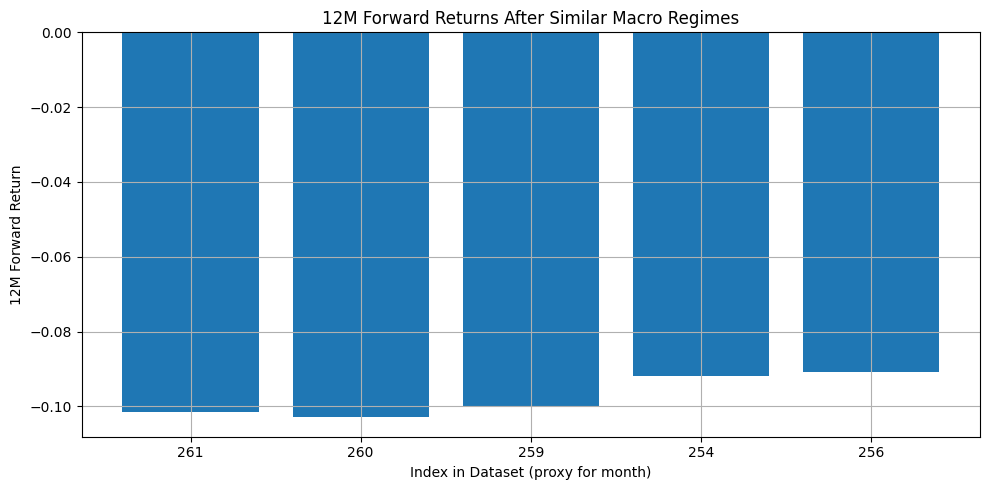

In [11]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/ML-Portfolio/data/cleaned_for_modeling.csv')

# Optional: parse date if exists
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])

# Use these updated features and target
features = ['CPI_lag_0', 'US Interest Rate_lag_6', 'Dollar Index (DXY)']
target = 'wine_12m_ret'

# Clean missing data
df[features + [target]] = df[features + [target]].fillna(method='ffill').fillna(method='bfill')

# Prepare KNN
X = df[features]
X_scaled = (X - X.mean()) / X.std()

knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn.fit(X_scaled)

# Use latest macro vector
x_current = X_scaled.iloc[-1].values.reshape(1, -1)
distances, indices = knn.kneighbors(x_current)

# Display results
print("\n🔍 Most similar historical observations:")
print(df.iloc[indices[0]][['Liv-ex 100'] + features + [target]])

# Plot forward returns
plt.figure(figsize=(10, 5))
plt.bar(df.iloc[indices[0]].index.astype(str), df.iloc[indices[0]][target])
plt.title("12M Forward Returns After Similar Macro Regimes")
plt.xlabel("Index in Dataset (proxy for month)")
plt.ylabel("12M Forward Return")
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Define features and binary target
features = ['CPI_lag_0', 'US Interest Rate_lag_6', 'Dollar Index (DXY)', 'wine_vol_12m', 'drawdown']
target_col = 'wine_12m_ret'

# Create binary label for bullish: return > 5%
df['Bullish'] = (df[target_col] > 0.05).astype(int)

# Drop rows with missing data
df_model = df[features + ['Bullish']].dropna()

# Step 2: Train/test split
X = df_model[features]
y = df_model['Bullish']
X_scaled = (X - X.mean()) / X.std()  # standardize

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# Step 3: Fit logistic regression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)

# Step 4: Evaluate
y_pred = logreg.predict(X_test)
print("\n🔍 Classification Report:")
print(classification_report(y_test, y_pred))
print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Step 5: Add probabilities back to main DataFrame
df.loc[df_model.index, 'Bullish_Prob'] = logreg.predict_proba(X_scaled)[:, 1]



🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        44
           1       0.79      0.58      0.67        19

    accuracy                           0.83        63
   macro avg       0.81      0.76      0.77        63
weighted avg       0.82      0.83      0.82        63

📊 Confusion Matrix:
[[41  3]
 [ 8 11]]


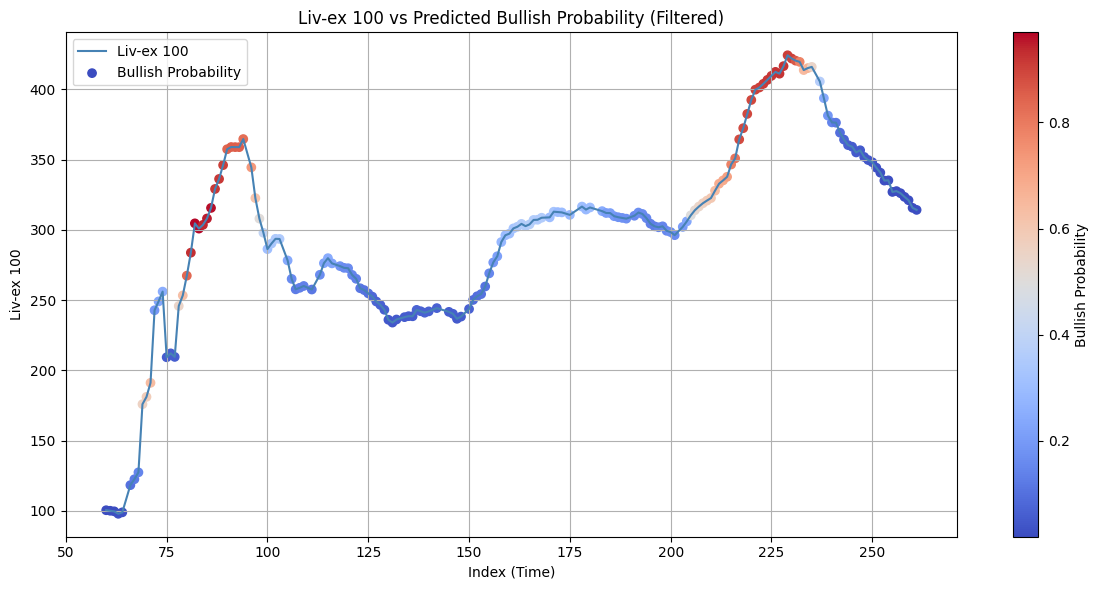

In [15]:
import matplotlib.pyplot as plt

# Step 1: Filter out rows where Liv-ex 100 is constant or suspicious
# We'll remove rows where there's no change in Liv-ex over the last 3 months
df['Livex_Change'] = df['Liv-ex 100'].diff(3).abs()
df_filtered = df[(df['Livex_Change'] > 1) & (~df['Bullish_Prob'].isna())]

# Step 2: Plot clean overlay
plt.figure(figsize=(12, 6))

plt.plot(df_filtered.index, df_filtered['Liv-ex 100'], label='Liv-ex 100', color='steelblue')

sc = plt.scatter(df_filtered.index,
                 df_filtered['Liv-ex 100'],
                 c=df_filtered['Bullish_Prob'],
                 cmap='coolwarm', label='Bullish Probability')

plt.title("Liv-ex 100 vs Predicted Bullish Probability (Filtered)")
plt.xlabel("Index (Time)")
plt.ylabel("Liv-ex 100")
plt.colorbar(sc, label='Bullish Probability')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
# Define Reversion: price was low but snapped back (12M return > 5%) and price was stressed
df['Reversion'] = ((df['wine_12m_ret'] > 0.05) & (df['drawdown'] < -0.1)).astype(int)



📈 Forward Return Regression Model Performance:
R² Score:  0.9412003126513213
RMSE:      0.06245061340895693


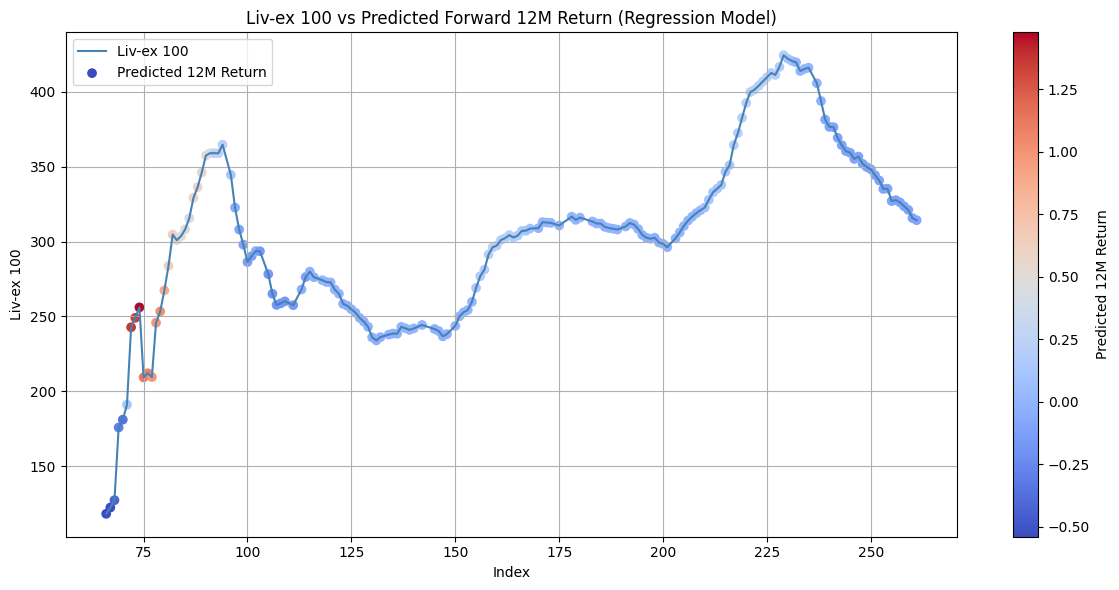

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# ─────────────────────────────────────────────
# STEP 1: FEATURE ENGINEERING
# ─────────────────────────────────────────────

df['rolling_peak'] = df['Liv-ex 100'].rolling(window=6, min_periods=1).max()
df['drawdown_pct'] = (df['Liv-ex 100'] - df['rolling_peak']) / df['rolling_peak']
df['drawdown_z'] = (df['drawdown'] - df['drawdown'].mean()) / df['drawdown'].std()
df['rolling_min'] = df['Liv-ex 100'].rolling(12, min_periods=1).min()
df['rolling_min_gap'] = df['Liv-ex 100'] - df['rolling_min']
df['pct_from_min'] = (df['Liv-ex 100'] - df['rolling_min']) / df['rolling_min']

# Momentum proxy
if 'momentum_direction_change' in df.columns:
    df['momentum_change'] = df['momentum_direction_change']
else:
    df['momentum_change'] = df['Liv-ex 100'].diff().apply(lambda x: 1 if x > 0 else 0)

# ─────────────────────────────────────────────
# STEP 2: RANDOM FOREST REGRESSION
# ─────────────────────────────────────────────

features = [
    'CPI_lag_6',
    'US Interest Rate_lag_6',
    'Dollar Index (DXY)',
    'drawdown_z',
    'wine_vol_12m',
    'rolling_min_gap',
    'pct_from_min',
    'momentum_change'
]

target_col = 'wine_12m_ret'
df_regression = df[features + [target_col]].dropna()
X = df_regression[features]
y = df_regression[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

rf_reg = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_reg.fit(X_train, y_train)

y_pred = rf_reg.predict(X_test)

print("\n📈 Forward Return Regression Model Performance:")
print("R² Score: ", r2_score(y_test, y_pred))
print("RMSE:     ", np.sqrt(mean_squared_error(y_test, y_pred)))

# Predict for full dataset
df.loc[df_regression.index, 'Predicted_12M_Return'] = rf_reg.predict(X)

# ─────────────────────────────────────────────
# STEP 3: PLOT OVERLAY (WITH ROBUST TIME AXIS)
# ─────────────────────────────────────────────

# Try to use date column or datetime index
if 'Date' in df.columns:
    df['Plot_Date'] = pd.to_datetime(df['Date'])
    time_col = 'Plot_Date'
elif isinstance(df.index, pd.DatetimeIndex):
    df['Plot_Date'] = df.index
    time_col = 'Plot_Date'
else:
    df['Plot_Date'] = df.index
    time_col = 'Plot_Date'

# Build filtered plot DataFrame
df_plot = df[['Plot_Date', 'Liv-ex 100', 'Predicted_12M_Return']].copy()
df_plot['Livex_Change'] = df_plot['Liv-ex 100'].diff(3).abs()
df_plot = df_plot.dropna()
df_plot = df_plot[df_plot['Livex_Change'] > 1]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_plot[time_col], df_plot['Liv-ex 100'], label='Liv-ex 100', color='steelblue')

sc = plt.scatter(df_plot[time_col],
                 df_plot['Liv-ex 100'],
                 c=df_plot['Predicted_12M_Return'],
                 cmap='coolwarm',
                 label='Predicted 12M Return')

plt.title("Liv-ex 100 vs Predicted Forward 12M Return (Regression Model)")
plt.xlabel("Date" if 'Date' in df.columns or isinstance(df.index, pd.DatetimeIndex) else "Index")
plt.ylabel("Liv-ex 100")
plt.colorbar(sc, label='Predicted 12M Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
